In [16]:
import pandas as pd
import unicodedata
import itertools
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS


DatosV = pd.read_excel("C:/Users/Felipe Bañol/Documents/GitHub/Metro2.0/DatosV.xlsx")
DatosV["EDAD"] = pd.to_numeric(DatosV["EDAD"], errors="coerce")

In [17]:

DatosV = DatosV[DatosV["AñoT"] >= "2012-1"]
DatosV["ESTACION"] = DatosV["ESTACION"].replace("SAN ANTONIO B", "SAN ANTONIO")
DatosV["ESTACION"] = DatosV["ESTACION"].replace("SAN JAVIER J", "SAN JAVIER")
estaciones_validas = [
    "NIQUIA", "BELLO", "MADERA", "ACEVEDO", "TRICENTENARIO", "CARIBE", "UNIVERSIDAD",
    "HOSPITAL", "PRADO", "PARQUE BERRIO", "SAN ANTONIO", "ALPUJARRA", "EXPOSICIONES",
    "INDUSTRIALES", "POBLADO", "AGUACATALA", "AYURA", "ENVIGADO", "ITAGUI", "SABANETA", "LA ESTRELLA", "SAN JAVIER", "SANTA LUCIA", "FLORESTA","ESTADIO", "SURAMERICANA","CISNEROS"
]

DatosV = DatosV[DatosV["ESTACION"].isin(estaciones_validas)]
type(DatosV["AñoT"])

pandas.core.series.Series

In [18]:
# 1️⃣ Crear lista de trimestres desde 2012-1 hasta 2023-4 para masculino
años = range(2012, 2024)
trimestres = [1, 2, 3, 4]
todos_trimestres = [f"{año}-{t}" for año, t in itertools.product(años, trimestres)]

# 2️⃣ Obtener lista de estaciones únicas (por ejemplo de DatosM)
estaciones = DatosV["ESTACION"].unique()

# 3️⃣ Crear DataFrame con todas las combinaciones de Estación x AñoT
combinaciones = pd.MultiIndex.from_product([estaciones, todos_trimestres], names=["ESTACION", "AñoT"]).to_frame(index=False)

# 4️⃣ Hacer conteo de ocurrencias en DatosM
conteo = DatosV.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")

# 5️⃣ Hacer merge con todas las combinaciones, rellenando NaN con 0
Datos_conteo = combinaciones.merge(conteo, on=["ESTACION", "AñoT"], how="left").fillna(0)

# 6️⃣ Asegurarse que 'conteo' sea entero
Datos_conteo["conteo"] = Datos_conteo["conteo"].astype(int)

# Ver los primeros registros

Datos_conteo

,ESTACION,AñoT,conteo
0,ACEVEDO,2012-1,0
1,ACEVEDO,2012-2,2
2,ACEVEDO,2012-3,1
3,ACEVEDO,2012-4,0
4,ACEVEDO,2013-1,0
...,...,...,...
1291,UNIVERSIDAD,2022-4,1
1292,UNIVERSIDAD,2023-1,3
1293,UNIVERSIDAD,2023-2,0
1294,UNIVERSIDAD,2023-3,1


In [19]:
DatosM = DatosV[DatosV["GENERO"] == "M"]
DatosF = DatosV[DatosV["GENERO"] == "F"]
Datos_joven = DatosV[DatosV["EDAD"] <= 28]
Datos_no_joven = DatosV[DatosV["EDAD"] > 28]
DatosM_joven = DatosV[(DatosV["GENERO"] == "M") & (DatosV["EDAD"] <= 28)]
DatosF_joven = DatosV[(DatosV["GENERO"] == "F") & (DatosV["EDAD"] <= 28)]
DatosM_no_joven = DatosV[(DatosV["GENERO"] == "M") & (DatosV["EDAD"] > 28)]
DatosF_no_joven = DatosV[(DatosV["GENERO"] == "F") & (DatosV["EDAD"] > 28)]



In [20]:
#Masculino#
conteoM = DatosM.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteoM = combinaciones.merge(conteoM, on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteoM["conteo"] = Datos_conteoM["conteo"].astype(int)
#Femenino#
conteoF = DatosF.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteoF = combinaciones.merge(conteoF, on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteoF["conteo"] = Datos_conteoF["conteo"].astype(int)
#Joven total#
conteo_joven = Datos_joven.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteo_joven = combinaciones.merge(conteo_joven, on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteo_joven["conteo"] = Datos_conteo_joven["conteo"].astype(int)
#No Joven total#
conteo_no_joven = Datos_no_joven.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteo_no_joven = combinaciones.merge(conteo_no_joven, on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteo_no_joven["conteo"] = Datos_conteo_no_joven["conteo"].astype(int)
#Masculino Joven#
conteoM_joven = DatosM_joven.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteoM_joven = combinaciones.merge(conteoM_joven, on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteoM_joven["conteo"] = Datos_conteoM_joven["conteo"].astype(int)
#Femenino Joven# 
conteoF_joven = DatosF_joven.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteoF_joven = combinaciones.merge(conteoF_joven, on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteoF_joven["conteo"] = Datos_conteoF_joven ["conteo"].astype(int)
#Masculino No Joven#    
conteoM_no_joven = DatosM_no_joven.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteoM_no_joven = combinaciones.merge(conteoM_no_joven       , on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteoM_no_joven["conteo"] = Datos_conteoM_no_joven["conteo"].astype(int)
#Femenino No Joven#
conteoF_no_joven = DatosF_no_joven.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
Datos_conteoF_no_joven = combinaciones.merge(conteoF_no_joven       , on=["ESTACION", "AñoT"], how="left").fillna(0)
Datos_conteoF_no_joven["conteo"] = Datos_conteoF_no_joven["conteo"].astype(int)                                        

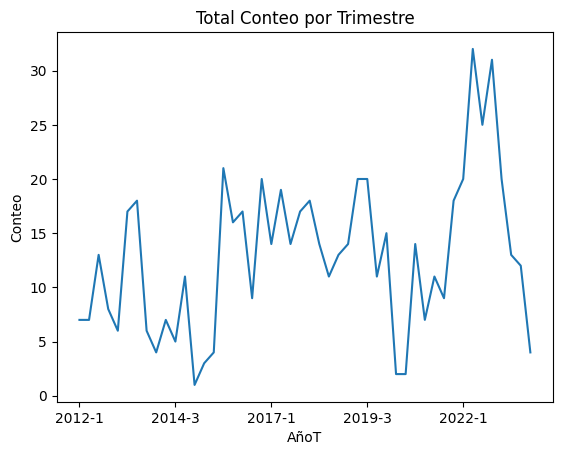

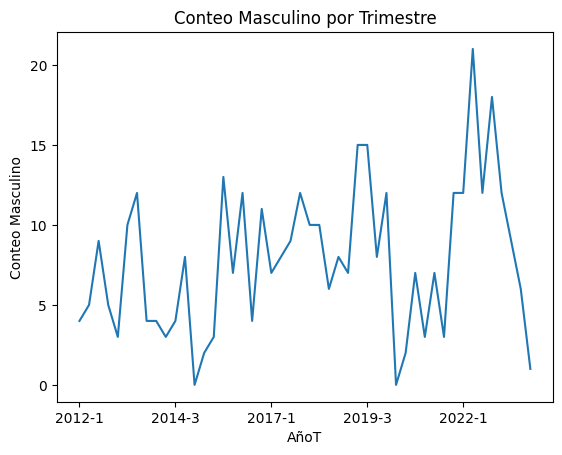

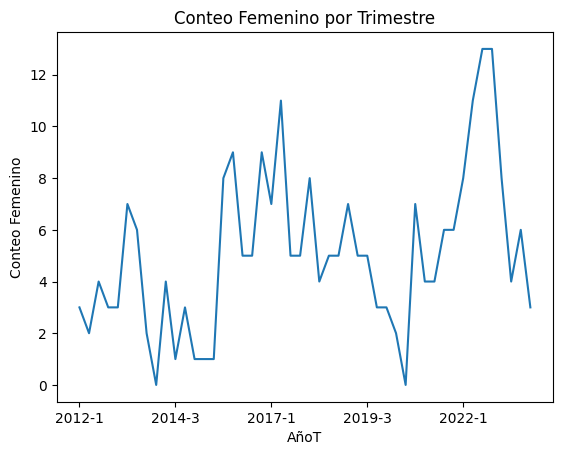

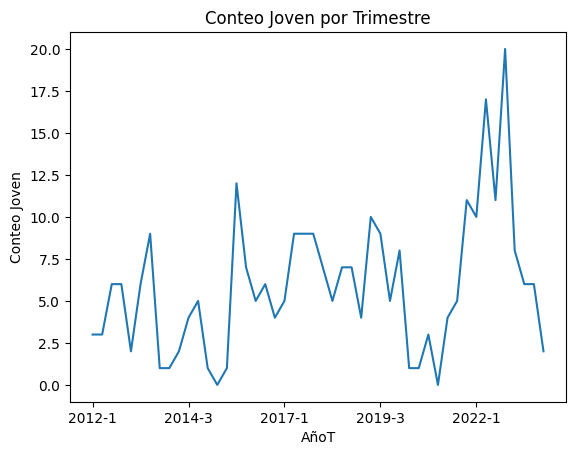

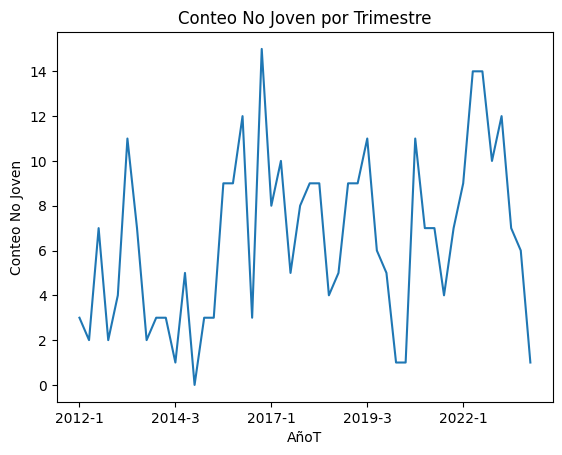

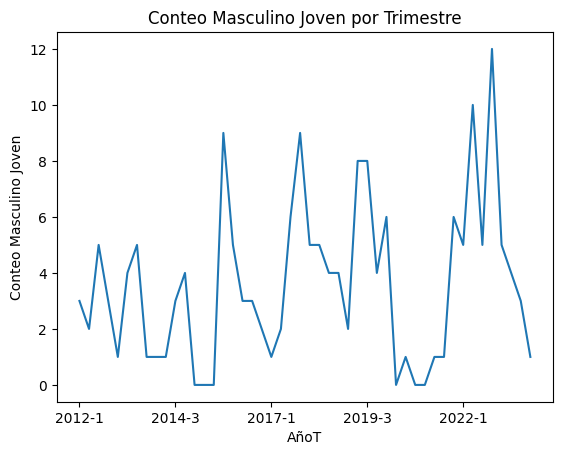

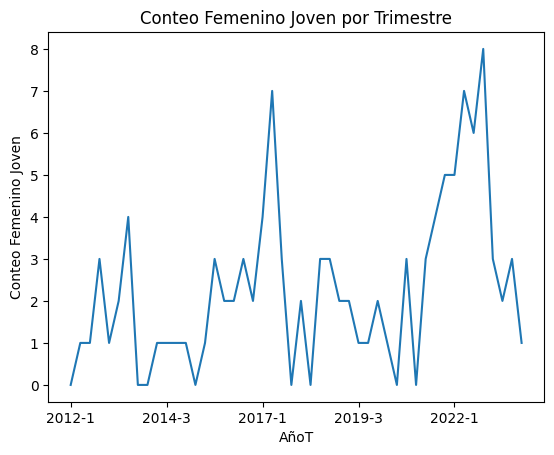

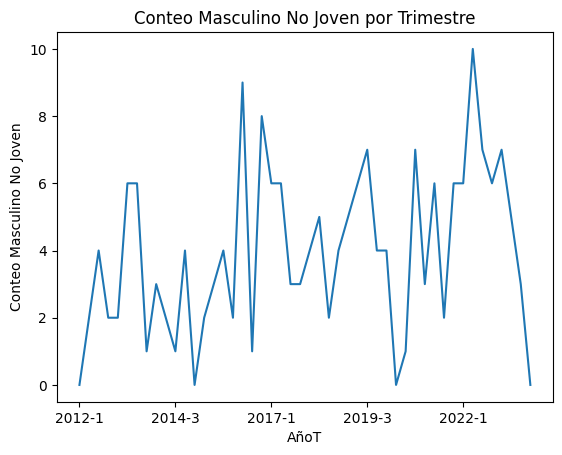

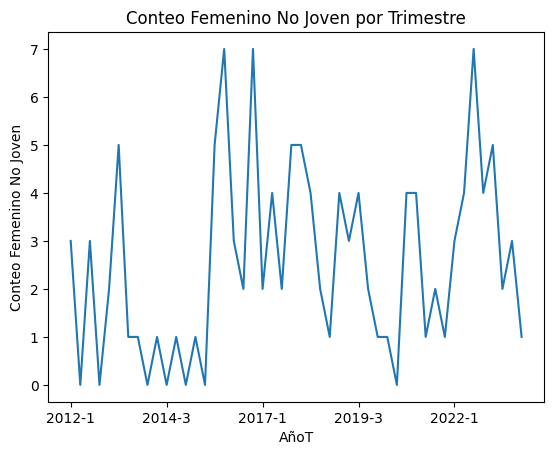

In [21]:
# Plot for Datos_conteo
Datos_conteo.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Total Conteo por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo')
plt.show()

# Plot for Datos_conteoM
Datos_conteoM.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino')
plt.show()

# Plot for Datos_conteoF
Datos_conteoF.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino')
plt.show()

# Plot for Datos_conteo_joven
Datos_conteo_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Joven')
plt.show()

# Plot for Datos_conteo_no_joven
Datos_conteo_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo No Joven')
plt.show()

# Plot for Datos_conteoM_joven
Datos_conteoM_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino Joven')
plt.show()

# Plot for Datos_conteoF_joven
Datos_conteoF_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino Joven')
plt.show()

# Plot for Datos_conteoM_no_joven
Datos_conteoM_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino No Joven')
plt.show()

# Plot for Datos_conteoF_no_joven
Datos_conteoF_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino No Joven')
plt.show()

In [22]:
def agregar_variables(df):
    # 1) Treat: estaciones tratadas
    estaciones_tratadas = ["ACEVEDO", "SAN ANTONIO", "SAN JAVIER"]
    df["Treat"] = df["ESTACION"].isin(estaciones_tratadas).astype(int)

    # 2) Time2020: periodos desde 2020-2 hasta 2024-4
    periodos_2020 = [
        "2020-2", "2020-3", "2020-4",
        "2021-1", "2021-2", "2021-3", "2021-4",
        "2022-1", "2022-2", "2022-3", "2022-4",
        "2023-1", "2023-2", "2023-3", "2023-4",
        "2024-1", "2024-2", "2024-3", "2024-4"
    ]
    df["Time2020"] = df["AñoT"].isin(periodos_2020).astype(int)

    # 3) Time2022: periodos desde 2022-1 hasta 2024-4
    periodos_2022 = [
        "2022-1", "2022-2", "2022-3", "2022-4",
        "2023-1", "2023-2", "2023-3", "2023-4",
        "2024-1", "2024-2", "2024-3", "2024-4"
    ]
    df["Time2022"] = df["AñoT"].isin(periodos_2022).astype(int)

    # 4) TimeT2020 = Treat * Time2020
    df["TimeT2020"] = df["Treat"] * df["Time2020"]

    # 5) TimeT2022 = Treat * Time2022
    df["TimeT2022"] = df["Treat"] * df["Time2022"]

    return df

# Aplicar a cada DataFrame relevante
DatosV = agregar_variables(DatosV)
DatosM = agregar_variables(DatosM)
DatosF = agregar_variables(DatosF)
Datos_joven = agregar_variables(Datos_joven)
Datos_no_joven = agregar_variables(Datos_no_joven)
DatosM_joven = agregar_variables(DatosM_joven)
DatosF_joven = agregar_variables(DatosF_joven)
DatosM_no_joven = agregar_variables(DatosM_no_joven)
DatosF_no_joven = agregar_variables(DatosF_no_joven)
Datos_conteo = agregar_variables(Datos_conteo)
Datos_conteoM = agregar_variables(Datos_conteoM)
Datos_conteoF = agregar_variables(Datos_conteoF)
Datos_conteo_joven = agregar_variables(Datos_conteo_joven)
Datos_conteo_no_joven = agregar_variables(Datos_conteo_no_joven)
Datos_conteoM_joven = agregar_variables(Datos_conteoM_joven)
Datos_conteoF_joven = agregar_variables(Datos_conteoF_joven)
Datos_conteoM_no_joven = agregar_variables(Datos_conteoM_no_joven)
Datos_conteoF_no_joven = agregar_variables(Datos_conteoF_no_joven)
Datos_conteo

C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_1628\3594320905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Treat"] = df["ESTACION"].isin(estaciones_tratadas).astype(int)
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_1628\3594320905.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time2020"] = df["AñoT"].isin(periodos_2020).astype(int)
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_1628\3594320905.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,ESTACION,AñoT,conteo,Treat,Time2020,Time2022,TimeT2020,TimeT2022
0,ACEVEDO,2012-1,0,1,0,0,0,0
1,ACEVEDO,2012-2,2,1,0,0,0,0
2,ACEVEDO,2012-3,1,1,0,0,0,0
3,ACEVEDO,2012-4,0,1,0,0,0,0
4,ACEVEDO,2013-1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1291,UNIVERSIDAD,2022-4,1,0,1,1,0,0
1292,UNIVERSIDAD,2023-1,3,0,1,1,0,0
1293,UNIVERSIDAD,2023-2,0,0,1,1,0,0
1294,UNIVERSIDAD,2023-3,1,0,1,1,0,0


In [ ]:

def trimestre_to_date(tri):
    año, t = tri.split('-')
    mes = (int(t)-1)*3 + 1
    return pd.Timestamp(year=int(año), month=mes, day=1)
Datos_conteo['AñoT_fecha'] = Datos_conteo['AñoT'].apply(trimestre_to_date)
Datos_conteo_panel = Datos_conteo.set_index(['ESTACION', 'AñoT_fecha']).sort_index()

# 2️⃣ Ajustar modelo
modelo = PanelOLS.from_formula(
    "conteo ~ Treat + Time2020 + TimeT2020 + EntityEffects",
    data=Datos_conteo_panel,
    drop_absorbed=True
)

# 3️⃣ Estimar con errores robustos
res = modelo.fit(cov_type="robust")
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 conteo   R-squared:                        0.0040
Estimator:                   PanelOLS   R-squared (Between):              0.0980
No. Observations:                1296   R-squared (Within):               0.0040
Date:                Sun, Aug 17 2025   R-squared (Overall):              0.0371
Time:                        21:21:37   Log-likelihood                   -1476.0
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.5315
Entities:                          27   P-value                           0.0799
Avg Obs:                       48.000   Distribution:                  F(2,1267)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):             1.7713
                            

C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_1628\3828402665.py:17: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Treat

  res = modelo.fit(cov_type="robust")
